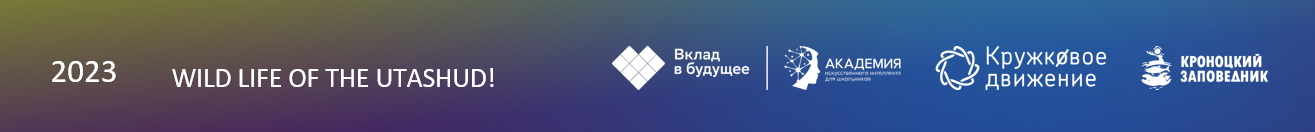

# Дикая жизнь Уташуда! Про тюленев.
# The wild life of Utashud! About seals.


Привет, друг! Перед тобой бейзлайн хакатона "Дикая жизнь Уташуда", который проходит с 10 по 27 августа 2023 года. Этот бейзлайн позволит получить простое, но рабочее решение решение по классификации снимков с фотоловушек на те, где есть тюлени и на те, где тюленей нет. Он позволяет получить тот результат, который можно загрузить на платформу провденеия соревнования и закрепить за собой место в рейтинге и право звания участника. Помни, что это самое простое решение, которе необходимо значительно дорабатывать.

Этот бейзлайн презназначен только для участников трека "To continue".

***

Hello, dear friend! This is the baseline for "Wild life of Utashud!" Hack, which runs from  08/10/2023 to 08/27/2023. This baseline will allow you to get a simple but working solution for classifying images from camera traps into those where there are seals and those where there are no seals. It allows you to get the result that can be uploaded to the competition platform and get a place in the leaderboard to become a participant. Remember that this is the simplest solution that needs to be significantly improved.

This baseline is useful only for members of the track "To continue".

## Загрузка библиотек

In [ ]:
import numpy as np
import torch
from glob import glob
import os
from PIL import Image
import torchvision
from matplotlib import pyplot as plt
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm.notebook import tqdm
import warnings
import cv2
import random
from mpl_toolkits.axes_grid1 import ImageGrid

warnings.filterwarnings("ignore")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Running on {device}')

Running on cuda


## Загрузка датасета
## Dataset download

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!curl -o /content/drive/MyDrive/hakaton/train.zip -L#здесь необходимо поставить ссылку на то, где у вас лежит датасет Link to your downloaded here
!unzip -q /content/drive/MyDrive/hakaton/train.zip

curl: option -L#здесь: is unknown
curl: try 'curl --help' or 'curl --manual' for more information
replace train/no_seal/20200520_194550_01_JPG.rf.48a9c2929d3c03a3935a06df5d3cd4b0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!curl -o /content/drive/MyDrive/hakaton/test.zip -L#здесь необходимо поставить ссылку на то, где у вас лежит датасет Link to your downloaded here
!unzip -q /content/drive/MyDrive/hakaton/test.zip

curl: option -L#здесь: is unknown
curl: try 'curl --help' or 'curl --manual' for more information
replace __MACOSX/._test? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Для начала посмотрим фото с тюленями.

***

First, let's look at photos with seals.

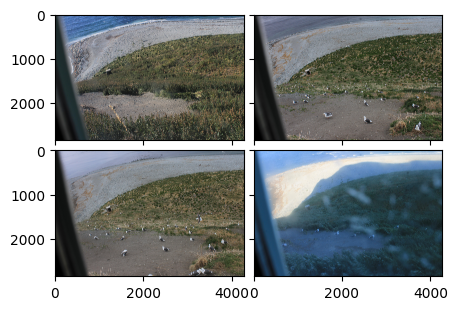

In [ ]:
fig = plt.figure(figsize=(5., 5.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(2, 2),
                 axes_pad=0.1,
                 )

pathes = glob('train/seal/*') #пути ко всем файлам в папке
images = [cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) for img in random.choices(pathes, k = 4)] #выбираем 4 случайных фото и переводим их в RGB (OpenCV хранит фото в цветовом окружение BGR)

for ax, im in zip(grid, images):
    ax.imshow(im)

plt.show()

А теперь без.

***

And without seals.

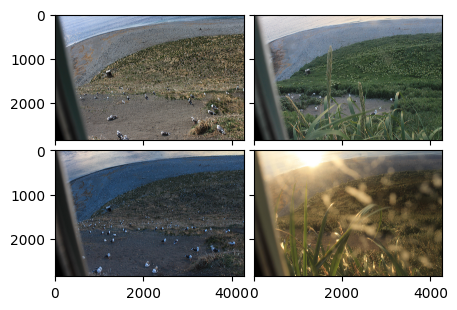

In [ ]:
fig = plt.figure(figsize=(5., 5.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(2, 2),
                 axes_pad=0.1,
                 )

pathes = glob('train/no_seal/*') #пути ко всем файлам в папке path to the all files
images = [cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) for img in random.choices(pathes, k = 4)] #выбираем 4 случайных фото и переводим их в RGB (OpenCV хранит фото в цветовом окружение BGR)

for ax, im in zip(grid, images):
    ax.imshow(im)

plt.show()

Создадим класс датасета: определим, как изображения будут читаться и передаваться в модель. Можете заметить что часть ыото обрезается: это сделано специально. Это нужно для того что бы отбросить не нужную нам часть с чайками.

***

Let's create a dataset class: define how images will be read and passed to the model. You may notice that part of it is cut off: this is done on purpose. This is necessary in order to discard the part we do not need with seagulls.

In [ ]:
class SealDataset(Dataset):
    def __init__(self, root_path, transform=None):
        super().__init__()
        self.transform = transform
        self.image_paths = []
        self.labels = []
        for cls in ['no_seal', 'seal']:
            for file_path in glob(os.path.join(root_path, cls, '*.jpg')):
                self.image_paths.append(file_path)
                self.labels.append(1 if cls == 'seal' else 0)

    def __getitem__(self, i):
        image = np.array(Image.open(self.image_paths[i]))
        image = image[:image.shape[0]//2]
        label = self.labels[i]
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.labels)

Зададим трансформации изображений, которые будут произведены прежде чем они попадут в модель.

***

Let's set the transformations of the images that will be performed before they get into the model.

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((230, 230)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
dataset = SealDataset(root_path='/content/train', transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

Посмотрим, какая доля картинок с тюленями.

***

Let's see the proportion of pictures with seals.

In [ ]:
print(f"{sum(dataset.labels)/len(dataset)*100:.2f}% картинок содержат тюленей/photos with seals")

59.69% картинок содержат тюленей/photos with seals


Как мы видим, в целом датасет довольно сбалансированный.

***

As we can see, the dataset is quite balanced.

Создадим загрузчики данных.

***

Let's create the dataloaders.

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

## Модель для классификации
## Classification model

Возьмем модель ResNet18 из torchvision.models.
Для бинарной классификации нужно изменить размерность выходного слоя модели с 1000 до 1 нейрона.

***

Let's take the ResNet18 model from torchvision.models.
For binary classification, you need to change the dimension of the output layer of the model from 1000 to 1 neuron.

In [ ]:
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [ ]:
# class CustomKiller(nn.Module):
#     def __init__(self):
#         super(CustomKiller, self).__init__()
#         self.backbone = torchvision.models.efficientnet_v2_l(pretrained=True)
#         self.act1 = nn.ReLU()
#         self.linl = nn.Linear(1000, 1)
#     def forward(self, x):
#         x = self.act1(self.backbone(x))
#         x = self.linl(x)
#         return x


# model = CustomKiller().to(device)

In [ ]:
# model = torchvision.models.efficientnet_v2_l(pretrained=True)

# for param in model.parameters():
#     param.requires_grad = False

# model.act1 = nn.ReLU()
# model.linl = nn.Linear(1000, 1)
# model.act2 = nn.Sigmoid()

# model = model.to(device)

In [ ]:
model = torchvision.models.resnet101(pretrained=True)

model.fc = nn.Linear(2048, 1)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 286MB/s]


Здесь задаем оптимизатор и лосс-функцию для обучения.

***

Here we set the optimizer and the loss function for training.

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

## Обучение
## Model training

Задаем функции обучения и валидации.

***

We set the training and validation functions.

In [ ]:
def train_loop(model, train_loader, optimizer, criterion, device):
    model.train()
    progress_bar = tqdm(train_loader)
    total_loss = 0
    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        out = model(images).squeeze(1)
        loss = criterion(out, labels.float())
        total_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()
    print(f'Average train loss: {total_loss / len(train_loader)}\n')
    return total_loss / len(train_loader)

In [ ]:
def val_loop(model, val_loader, optimizer, criterion, device):
    model.eval()
    progress_bar = tqdm(val_loader)
    total_loss = 0
    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        out = model(images).squeeze(1)
        loss = criterion(out, labels.float())
        total_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})
        torch.cuda.empty_cache()
    avg_loss = total_loss / len(val_loader)
    print(f'Average val loss: {avg_loss}\n')
    return avg_loss

In [ ]:
def train(model, train_loader, val_loader, optimizer, criterion, device, epochs=5):
    best_loss = float('inf')
    for epoch in range(epochs):
        print(f'--- Epoch {epoch + 1} ---')
        train_loss = train_loop(model, train_loader, optimizer, criterion, device)
        avg_loss = val_loop(model, val_loader, optimizer, criterion, device)
        if avg_loss < best_loss:
            best_loss = avg_loss
            print('Saving new best model...\n')
            torch.save(model.state_dict(), f'resnet18-{epoch}-{best_loss:.5f}.pt')

Запускаем обучение!

***

Start of the training!

In [ ]:
train(model, train_loader, val_loader, optimizer, criterion, device, epochs=5)

--- Epoch 1 ---


  0%|          | 0/18 [00:00<?, ?it/s]

Average train loss: 1.0231186035606596



  0%|          | 0/5 [00:00<?, ?it/s]

OutOfMemoryError: ignored

## Инференс модели
## Model inference

Немного о метрике. Метрика F1 является одной из самых распространенных и популярных метрик для оценки качества классификационной модели, особенно в задачах с несбалансированными классами. Она объединяет две метрики: точность (precision) и полнота (recall).

Precision (точность) - это доля правильно предсказанных объектов среди всех, которым модель присвоила класс positive (1). Такая метрика помогает понять, в скольких случаях модель правильно предсказывает позитивный класс.

\begin{equation}
Precision = \frac{TP}{TP+FP}
\end{equation}

Recall (полнота) - это доля тех объектов класса 1, которым модель правильно определила класс. Это позволяет узнать то, какую часть объектов искомого класса модель идентифицирует правильно. Такая метрика особенно важна в медицине, там она называется чувствительность. Подробнее можно прочитать [тут](https://www.msdmanuals.com/ru/%D0%BF%D1%80%D0%BE%D1%84%D0%B5%D1%81%D1%81%D0%B8%D0%BE%D0%BD%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B9/%D1%81%D0%BF%D0%B5%D1%86%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5-%D1%82%D0%B5%D0%BC%D1%8B/%D0%BE%D1%81%D0%BE%D0%B1%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B8-%D0%BF%D1%80%D0%B8%D0%BD%D1%8F%D1%82%D0%B8%D1%8F-%D0%BA%D0%BB%D0%B8%D0%BD%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B3%D0%BE-%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D1%8F/%D0%BF%D0%BE%D0%BD%D0%B8%D0%BC%D0%B0%D0%BD%D0%B8%D0%B5-%D0%BC%D0%B5%D0%B4%D0%B8%D1%86%D0%B8%D0%BD%D1%81%D0%BA%D0%B8%D1%85-%D1%82%D0%B5%D1%81%D1%82%D0%BE%D0%B2-%D0%B8-%D0%B8%D1%85-%D1%80%D0%B5%D0%B7%D1%83%D0%BB%D1%8C%D1%82%D0%B0%D1%82%D0%BE%D0%B2)

\begin{equation}
Recall = \frac{TP}{TP+FN}
\end{equation}

Для того, чтобы точно убедиться в понимании темы, посмотрим на так называемую матрицу ошибок (confusion matrix)

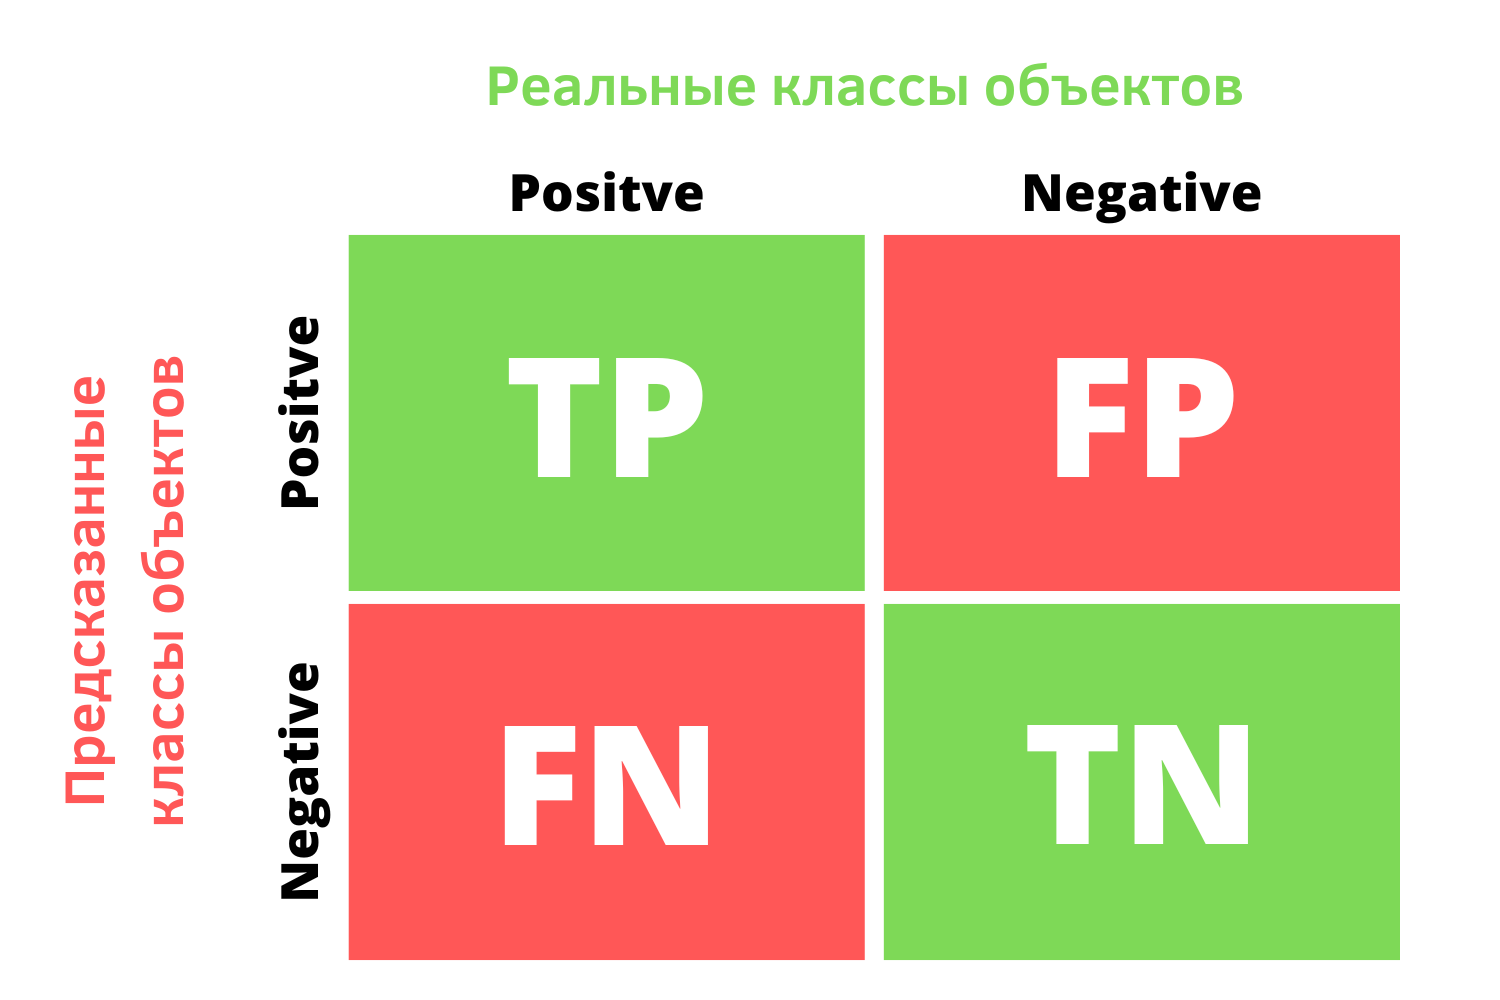

Теперь наконец формула F1-Score. Она выглядит так:
\begin{equation}
F1 = \frac{2*Precision*Recall}{Precision+Recall}
\end{equation}
F1-Score - среднее гармоническое от Precision и Recall. Это нужно для того, чтобы в случае несбалансированности датасета понимать, какая точность у модели будет во всех случаях.

A little about the metric. The F1 metric is one of the most common and popular metrics for assessing the quality of a classification model, especially in problems with unbalanced classes. It combines two metrics: precision (precision) and recall (recall).

Precision (accuracy) is the proportion of correctly predicted objects among all that the model has assigned the positive (1) class. Such a metric helps to understand in how many cases the model correctly predicts a positive class.

\begin{equation}
Precision = \frac{TP}{TP+FP}
\end{equation}

Recall (completeness) is the proportion of those objects of class 1 that the model correctly assigned a class to. This allows you to find out which part of the objects of the desired class the model identifies correctly. Such a metric is especially important in medicine, where it is called sensitivity. More details can be found [here](https://www.msdmanuals.com/ru/%D0%BF%D1%80%D0%BE%D1%84%D0%B5%D1%81%D1%81%D0%B8%D0%BE%D0%BD%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B9/%D1%81%D0%BF%D0%B5%D1%86%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5-%D1%82%D0%B5%D0%BC%D1%8B/%D0%BE%D1%81%D0%BE%D0%B1%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B8-%D0%BF%D1%80%D0%B8%D0%BD%D1%8F%D1%82%D0%B8%D1%8F-%D0%BA%D0%BB%D0%B8%D0%BD%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B3%D0%BE-%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D1%8F/%D0%BF%D0%BE%D0%BD%D0%B8%D0%BC%D0%B0%D0%BD%D0%B8%D0%B5-%D0%BC%D0%B5%D0%B4%D0%B8%D1%86%D0%B8%D0%BD%D1%81%D0%BA%D0%B8%D1%85-%D1%82%D0%B5%D1%81%D1%82%D0%BE%D0%B2-%D0%B8-%D0%B8%D1%85-%D1%80%D0%B5%D0%B7%D1%83%D0%BB%D1%8C%D1%82%D0%B0%D1%82%D0%BE%D0%B2)

\begin{equation}
Recall = \frac{TP}{TP+FN}
\end{equation}

In order to be sure of understanding the topic, let's look at the so-called error matrix

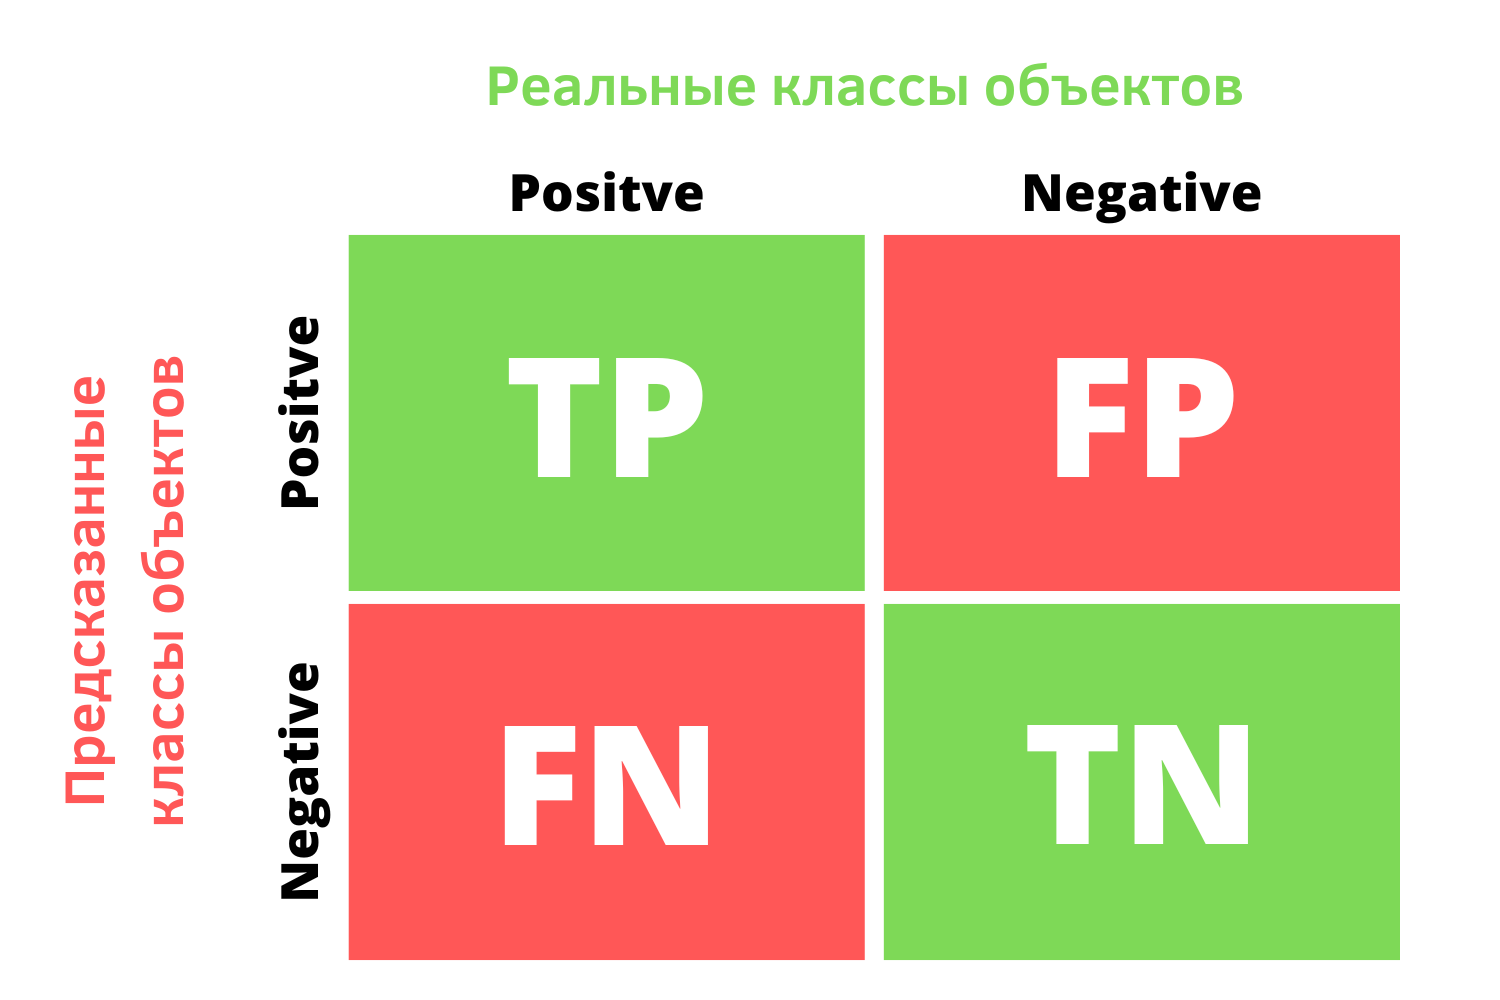

Now finally the F1-Score formula. It looks like this:
\begin{equation}
F1 = \frac{2*Precision*Recall}{Precision+Recall}
\end{equation}
F1-Score - harmonic mean from Precision and Recall. This is necessary in order to understand what accuracy the model will have in all cases in case of an imbalance in the dataset.

In [ ]:
# model = torchvision.models.resnet50(pretrained=True)
# model.fc = nn.Linear(2048, 1)
# model.load_state_dict(torch.load('/content/resnet18-2-0.58096.pt'))
# model = model.to(device)

In [ ]:
model.eval()
torch.cuda.empty_cache()
progress_bar = tqdm(val_loader)
y_pred, y_true = [], []
for images, labels in progress_bar:
    images = images.to(device)
    labels = labels.to(device).detach().tolist()
    y_true.extend(labels)
    out = model(images).squeeze(1) > 0
    out = out.detach().tolist()
    y_pred.extend(out)

In [ ]:
from sklearn.metrics import f1_score

f1_score(y_true, y_pred)

## Сохранение предсказаний
## Save our predictions

In [ ]:
import pandas as pd

paths = []
preds = []
for pth in glob('test/*'):
    img = np.array(Image.open(pth))
    img = transform(img).unsqueeze(0).to(device)
    results = model(img).sigmoid().round().item()
    preds.append(results)
    paths.append(pth.split('/')[-1])

df = pd.DataFrame(list(zip(paths, preds)), columns=['filename', 'class'])
df.to_csv('seals.csv', index=False)

## Как можно улучшить качество предсказаний?
1. Попробуйте различные манипуляции с изображениями
2. Поменяйте что-либо в архитектуре модели либо возьмите новую модель (можно посмотреть в [torchvision.models](https://pytorch.org/vision/stable/models.html) или в [timm](https://github.com/huggingface/pytorch-image-models))
3. Подумайте над тем, как можно увеличить датасет

***

## How can the quality of predictions be improved?
1. Try different image manipulations
2. Change something in the architecture of the model or use a new model (can be found in [torchvision.models](https://pytorch.org/vision/stable/models.html) or in [timm](https://github .com/huggingface/pytorch-image-models))
3. Think about how you can increase the dataset